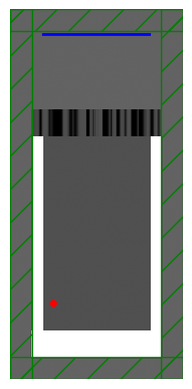

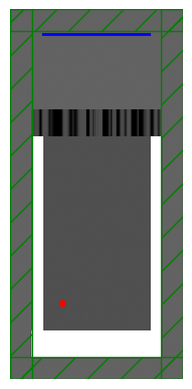

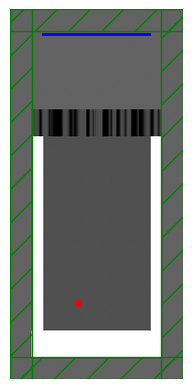

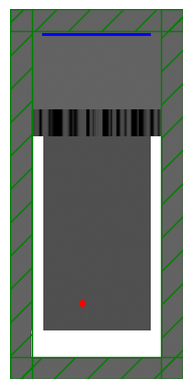

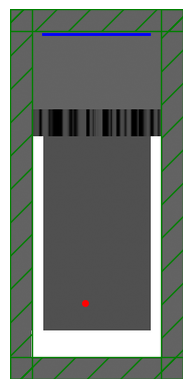

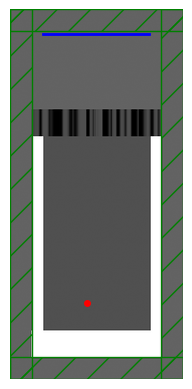

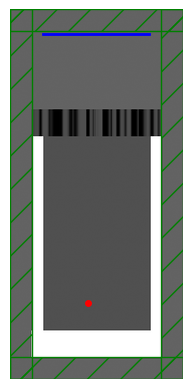

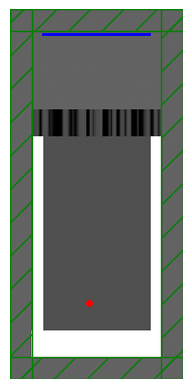

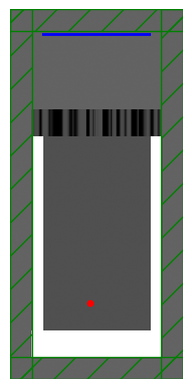

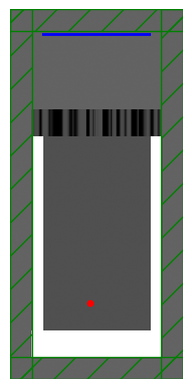

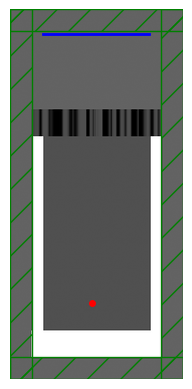

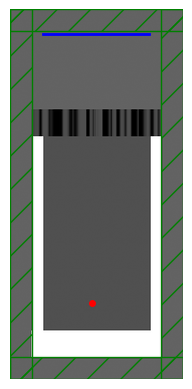

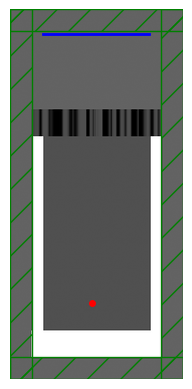

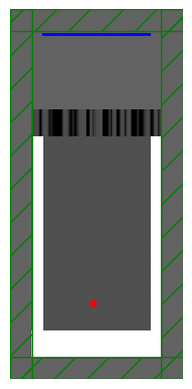

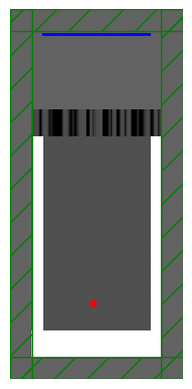

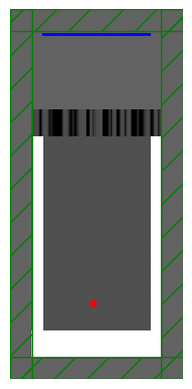

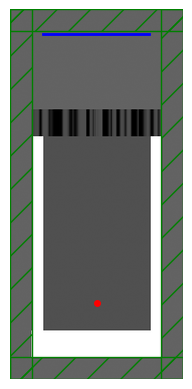

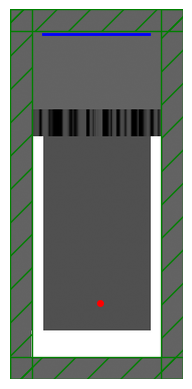

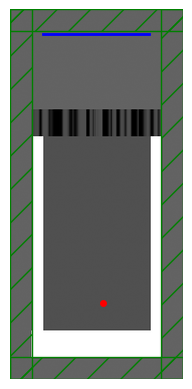

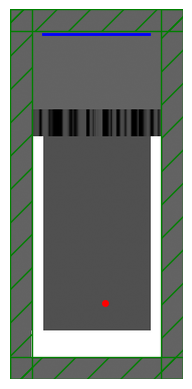

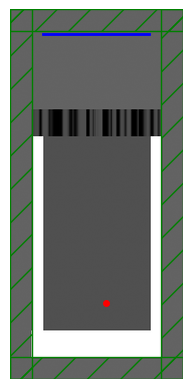

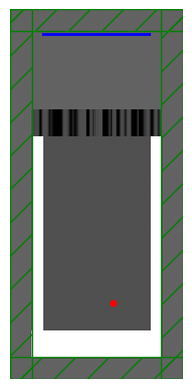

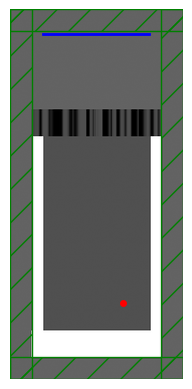

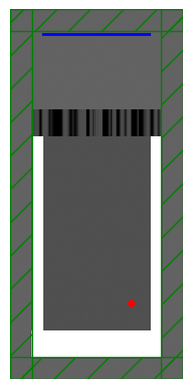

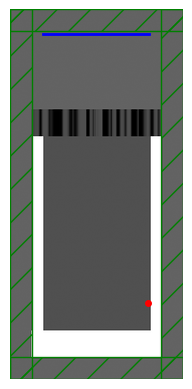

In [59]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

mp.verbosity(0)

fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

# nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭

# df= 0
nfreq = 1

tag_bot = 0.5
tag_side = 4
tsio2 = 4
monitor_position = 0.5 * 2
monitor_blank = 0.5 * 0.1
tpml = 0.4

width_ag = 0.2
width_sio2 = 2
width_bot_ag = round(width_ag + width_sio2 + width_ag,2)
design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

Sx = tpml + width_bot_ag + tpml
Sy = round(tpml + tag_bot + tag_side + design_region_height + monitor_position + monitor_blank + tpml, 3)
cell_size = mp.Vector3(Sx, Sy)

# 재료
SiO2 = mp.Medium(index=1.45)
TiO2 = mp.Medium(index=2.6)
Air = mp.Medium(index=1.0)

# 디자인 변수 격자
Nx = int(design_region_resolution * design_region_width) + 1
# Ny = int(design_region_resolution * design_region_height) + 1
Ny = 1


# 위치 계산
y_bottom = -Sy / 2
center_y_ag = y_bottom + tpml + tag_bot / 2
center_y_sio2 = y_bottom + tpml + tag_bot + tsio2 / 2
center_y_design = y_bottom + tpml + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tpml + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tpml + tag_bot + 1 / fcen
center_Ag_x_position = design_region_width / 2 - width_ag / 2

boundary_layers = [
    mp.Absorber(tpml, direction=mp.X),
    mp.PML(tpml, direction=mp.Y)
]

decom_size = width_bot_ag

geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]

# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )

        
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,

        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(

        
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )

def gen_x_positions(n, x_lo, x_hi, mode="randn", seed=None, min_sep=0.0, spacing=None):
    assert x_hi > x_lo
    if n <= 0: return []
    if n == 1:  return [0.5*(x_lo+x_hi)]
    L = x_hi - x_lo

    # 비랜덤(균등 간격)
    if mode in ("no-randn", "grid", "deterministic"):
        s = min(spacing or L/(n-1), L/(n-1))
        start = 0.5*(x_lo+x_hi) - 0.5*s*(n-1)
        return [start + i*s for i in range(n)]

    # 랜덤 배치 (균일/정규)
    rng = np.random.default_rng(seed)
    mu, sigma = 0.5*(x_lo+x_hi), L/6.0
    def sample():
        return np.clip(rng.normal(mu, sigma), x_lo, x_hi) if mode in ("randn","normal") else rng.uniform(x_lo, x_hi)

    xs = []
    for _ in range(10000):
        x = sample()
        if all(abs(x - xi) >= min_sep for xi in xs):
            xs.append(x)
            if len(xs) == n: break

    # 실패 시 간단 보강(균등분할)
    return sorted(xs if len(xs) == n else np.linspace(x_lo, x_hi, n).tolist())

num_sources = 25
min_sep = 0
margin  = 0.05
seed    = 3
x_lo, x_hi = -0.5*width_sio2 + margin, 0.5*width_sio2 - margin
y0 = center_y_source_position

xs = gen_x_positions(num_sources, x_lo, x_hi, mode="randn", seed=seed, min_sep=min_sep)   # "random" / "no-randn"
sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(x, y0, 0)
    )
    for x in xs
]

sources = [
    mp.Source(
        mp.CustomSource(src_func=lambda t: np.random.randn()),
        component=mp.Ez,
        center=mp.Vector3(x, y0)
    )
    for x in xs
]

k0 = mp.Vector3(0,0,0)

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag],
    )
    for src in sources
]

monitor_position_J = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(width_sio2-2/resolution, 0)

dft_monitor = []
k = np.loadtxt("/home/min/EIDL/Tool/Meep/LGD/LGD Project/Mode decomposition/Kyungmin/Reciprocity/ndipole1_resolution50_grating_loc0.5/example.txt")
design_variables.update_weights(k)
for i in range(num_sources):
    dft_monitor.append(sims[i].add_dft_fields([mp.Ez], fcen,0,1, center = monitor_position_J, size = monitor_size, yee_grid=True))
    sims[i].plot2D()
    plt.axis(False)
    plt.show()

In [60]:
dft_array = []

for i in range(num_sources):
    sims[i].run(until = 200)
    dft_array.append(sims[i].get_dft_array(dft_monitor[i], mp.Ez, 0))
    # sims[i].plot2D(fields = mp.Ez)  
    # plt.show()
    sims[i].reset_meep()

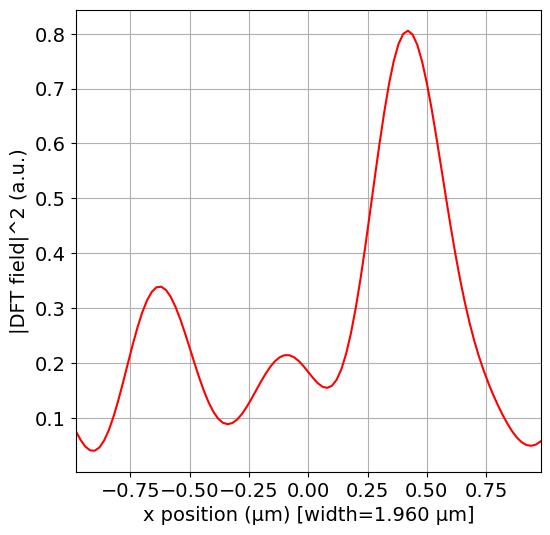

In [61]:
# 리스트 → 배열 변환(평균 계산을 위해)
dft_array = np.array(dft_array)

y = (np.abs(dft_array)**2).mean(axis=0)

num_pts  = y.size
x_coords = np.linspace(-monitor_size.x/2, monitor_size.x/2, num_pts)  # -W/2 ~ +W/2

plt.figure(figsize= (6,6))
plt.plot(x_coords, y, 'r-')
plt.xlabel(f"x position (μm) [width={monitor_size.x:.3f} μm]",fontsize = 14)
plt.ylabel("|DFT field|^2 (a.u.)", fontsize = 14)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(True)

plt.xlim(-monitor_size.x/2, monitor_size.x/2)
# plt.ylim(0,1)
plt.show()


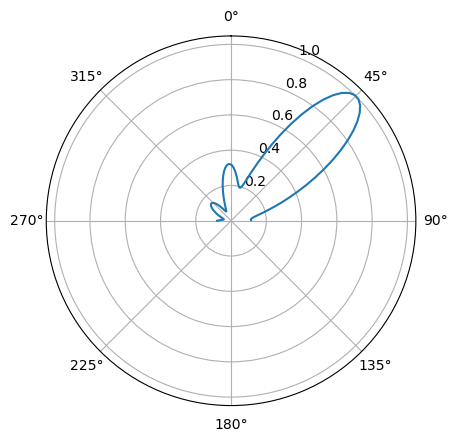

In [ ]:
# dft_array: 복소 1D 배열들의 리스트
arr = np.stack(dft_array, axis=0)           # (M, N)
mean_I = (np.abs(arr)**2).mean(axis=0)      # (N,) 평균 강도
mean_I /= mean_I.max()                      # (옵션) 정규화

# 각도 벡터(예: 0 ~ 2π). 필요하면 [-π/2, π/2]로 바꾸세요.
N = mean_I.size
theta = np.linspace(-np.pi/2, np.pi/2, N, endpoint=False)
# theta = np.linspace(-np.pi/2, np.pi/2, N)  # 대안

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(theta, mean_I)
ax.set_theta_zero_location('N')  # 0°=위쪽
ax.set_theta_direction(-1)       # 시계방향
plt.show()


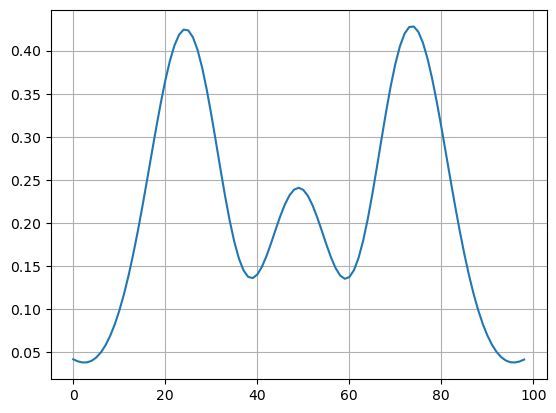

In [33]:
arr = np.stack(dft_array, axis=0)        # (M, N)


plt.plot((np.abs(arr)**2).mean(axis=0))
plt.grid(True)
plt.show()

<Axes: xlabel='X', ylabel='Y'>

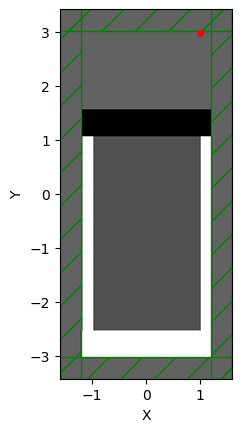

In [35]:
import os
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

# nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭
nfreq = 1

tag_bot = 0.5
tag_side = 4
tsio2 = 4
monitor_position = 0.5 * 2
monitor_blank = 0.5 * 0.1
tpml = 0.4

width_ag = 0.2
width_sio2 = 2
width_bot_ag = round(width_ag + width_sio2 + width_ag,2)
design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

# 시뮬레이션 셀 크기
Sx = tpml + width_bot_ag + tpml
Sy = round(tpml + tag_bot + tag_side + design_region_height + monitor_position + monitor_blank + tpml, 3)
cell_size = mp.Vector3(Sx, Sy)

# 재료
SiO2 = mp.Medium(index=1.45)
TiO2 = mp.Medium(index=2.6)
Air = mp.Medium(index=1.0)

# === Design mode 선택: 'grating' 또는 'free'
DESIGN_MODE = 'grating'   # 'free' 로 바꾸면 freeform 사용

# 디자인 변수 격자 크기
Nx = int(design_region_resolution * design_region_width) + 1
if DESIGN_MODE == 'grating':
    Ny = 1
else:
    Ny = int(design_region_resolution * design_region_height) + 1

# 위치 계산
y_bottom = -Sy / 2
center_y_ag = y_bottom + tpml + tag_bot / 2
center_y_sio2 = y_bottom + tpml + tag_bot + tsio2 / 2
center_y_design = y_bottom + tpml + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tpml + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tpml + tag_bot + 1 / fcen
center_Ag_x_position = design_region_width / 2 - width_ag / 2

boundary_layers = [
    mp.Absorber(tpml, direction=mp.X),
    mp.PML(tpml, direction=mp.Y)
]

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]

# 레이어 수
layer_num = 1
ML = (layer_num > 1)
region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )

num_sources = 1
spacing = 10 / resolution
offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(1, center_y_monitor_position, 0)
    )
    for offset in offsets
]

# ====== 출력 폴더 설정 ======
ndipole = num_sources
OUT_DIR = f"ndipole{ndipole}_resolution{resolution}_{DESIGN_MODE}_loc0.5s"
os.makedirs(OUT_DIR, exist_ok=True)

def save_figure(filename, dpi=200):
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, filename), dpi=dpi, bbox_inches="tight")
    plt.close()

k0 = mp.Vector3(0,0,0)

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag],
        # k_point=k0
    )
    for src in sources
]

sims[0].plot2D()

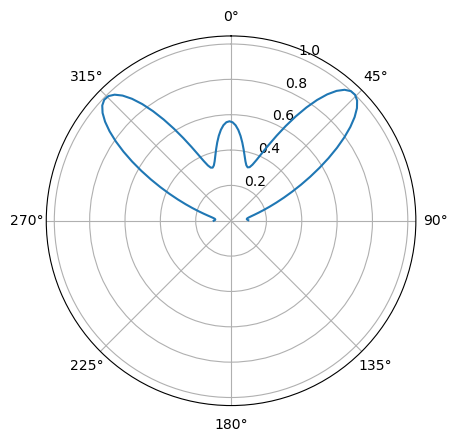

In [36]:
# dft_array: 복소 1D 배열들의 리스트
arr = np.stack(dft_array, axis=0)           # (M, N)
mean_I = (np.abs(arr)**2).mean(axis=0)      # (N,) 평균 강도
mean_I /= mean_I.max()                      # (옵션) 정규화

# 각도 벡터(예: 0 ~ 2π). 필요하면 [-π/2, π/2]로 바꾸세요.
N = mean_I.size
theta = np.linspace(-np.pi/2, np.pi/2, N, endpoint=False)
# theta = np.linspace(-np.pi/2, np.pi/2, N)  # 대안

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(theta, mean_I)
ax.set_theta_zero_location('N')  # 0°=위쪽
ax.set_theta_direction(-1)       # 시계방향
plt.show()
